In [441]:
#test the geo distance matrix, added in the function files
#weighted cluster method
library('data.table')
library('ggplot2')
library('ggmap')
library('dbscan')
library('dplyr')
library('xts')
#smu
funPath='D:/share/Git/Rprojects/ECA/function.R'
funPath2='../code/ShipTrajectoryAnalysisFunctions.R'
#funPath='D:/Git/Rprojects/ECA/function.R'
source(funPath)
source(funPath2)

In [ ]:
#get clusters
findCluster<-function(dt,eps=0.002,minp=10){
    
    temp1 <- as.matrix(dt[,list(lon,lat)])
    cl <- dbscan(temp1, eps = eps, minPts =minp)
    temp2=data.table(cbind(dt,c=cl$cluster));  
    return(temp2[c>0])
    
}

In [ ]:
#extract each trip from each cluster and mmsi
#input:candidate clusters
#output:cluster and duration for each ship in hours
findTrip<-function(dt,eps=6000*2,minp=5){
    
    temp3=dt[,.N,list(c,mmsi)]
    nr=nrow(temp3)#how many ships
    #nr=14
    tt=dt[mmsi<0];tt=tt[,c1:=0][c1<0]
    t0=data.table(mmsi=0,c=0,c1=0,dur=0)[mmsi<0]
    for (i in seq(1:nr)){
    r=temp3[i]
    cship=dt[mmsi==r$mmsi&c==r$c]
    setkey(cship,mmsi,time)
    cship2 <- as.matrix(cship[,list(time)])#get time series
    cl2 <- dbscan(cship2, eps = eps, minPts =minp)
    cship3=data.table(cbind(cship,c1=cl2$cluster));
    tt=rbind(tt,cship3)
    #if(nrow(cship3[c1>0])>0){
    #    t1=cship3[c1>0,list(dur=(max(.SD$time)-min(.SD$time))/3600),by=list(c,mmsi,c1)]
    #    t0=rbind(t0,t1) 
    #}
    }
    return(tt)

}


In [ ]:
#input eps is for dbscan to combine different clusters which actually at the same terminal but seperate by two or more grids
#eps set to be the doubel of the eps used to identify candidates terminals
#minp set to 2 as we only sample one point from each candidate cluster for combination purpose
getFinalCluster<-function(dt,eps=0.002*2,minp=2){
    sampled=dt[,.SD[median(1:.N)],list(glon,glat,c)]# the points produced with medium are representative
    cl=sampled[,.N,list(glon,glat,c)]
    cl=cbind(cl,cid=seq(1:nrow(cl)))#set new cluster ids
    
    sampled1=data.table(left_join(sampled,cl[,list(glon,glat,c,cid)],by=c('glon','glat','c')))
    cls=findCluster(sampled1[,list(c.org=c,glon,glat,lon,lat,cid)],eps,minp)#doubel the eps
    s2=cls[c>0,.N,list(glon,glat,c,c.org,cid)];
    s3=s2[,N,c];
    dt1=data.table(left_join(dt,cl[,list(glon,glat,c,cid)],by=c('glon','glat','c')))
    dt1=dt1[,fcid:=cid]#add final cluster identification
    #replace the cluster id at the same terminal
   
    for (i in unique(s2$c)){
        cids=s2[c==i]$cid
        dt1=dt1[fcid%in%cids,fcid:=min(cids)]  
    }
    return(dt1)    
}

In [ ]:
Sys.time()
dt=data.table(mmsi=0,time=0,status=0,sog=0,lon=0,lat=0)[mmsi<0]
path='D:/share/AIS/globalContainer2015/'
for(i in seq(201501,201512)){
    
    filepath=paste(path,i,sep='')
    temp=fread(filepath)[,list(mmsi,time,status,sog,lon,lat)];
    dt=rbind(dt,temp)
    }
Sys.time()

In [ ]:
setkey(dt,mmsi,time)

In [ ]:
dt0=dt[status==5&sog==0];head(dt0);dim(dt0);setkey(dt0,mmsi,time)

In [ ]:
nrow(dt0[,.N,mmsi])
nrow(candidates[,.N,mmsi])
nrow(selected[,.N,mmsi])

In [ ]:
#sample 
tmp=dt0[,atime:=align.time(as.POSIXct(time,origin='1970-01-01'),60*20)];dim(tmp);head(tmp);nrow(tmp[,.N,list(mmsi,atime)])
d5=tmp[,.SD[1],list(mmsi,atime)];dim(d5);head(d5)

In [389]:
#dim(d5);dim(d6);dim(tmp)
tmp=NULL;d5=NULL;d6=NULL

In [ ]:
#set grids
scale=2
d5=d5[,glon:=floor(lon*scale)/scale]
d5=d5[,glat:=floor(lat*scale)/scale]
d6=d5[,.N,list(glon,glat)]
setorder(d6,-N)
head(d6);nrow(d6)

In [ ]:
#combine results of all grids
st=Sys.time()
eps=0.002
minp=10
candidates=d5[mmsi<0];
candidates=candidates[,c:=0]
candidates=candidates[,c1:=0][c<0]
for (i in seq(1,nrow(d6))){
    print(i)
    r=d6[i]    
    temp=d5[glon==r$glon&glat==r$glat]
    temp2=findCluster(temp,eps,minp)
    if(nrow(temp2)>0){
        
    t0=findTrip(temp2)
    candidates=rbind(candidates,t0)
        
    }
    
}
Sys.time()-st

In [ ]:
head(candidates);dim(candidates[,.N,list(glon,glat,c)]);dim(candidates)

In [ ]:
nrow(candidates[,.N,list(glon,glat,c)])
nrow(candidates2[,.N,list(fcid)])

In [453]:
#dim(selected);
#selected=NULL
#candidates=NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,832896,44.5,2862368,152.9,39256625,2096.6
Vcells,5035045043,38414.4,10636464368,81149.8,8313504501,63427.1


In [ ]:
#add unique cluster cid and combine clusters belong to the same termainal
candidates2=getFinalCluster(candidates,0.004,2)#just use the selected replace the tempsample, here is only for test purpose
dim(candidates2);head(candidates2)
#head(sampled);dim(sampled)

In [ ]:
#number of trips with duration 168462
t1=candidates2[c>0&c1>0,list(dur=(max(.SD$time)-min(.SD$time))/3600),by=list(glon,glat,c,mmsi,c1,fcid)]
head(t1);dim(t1);

In [ ]:
hist(t1[fcid==676]$dur,breaks=100)
hist(t1[fcid==690]$dur,breaks=100)
hist(t1[fcid==2219]$dur,breaks=100)
hist(t1[fcid==1]$dur,breaks=100)

In [ ]:
#head(t0)
t2=t1[c>0&c1>0,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur),sd=sd(dur),.N),list(fcid)]
#t3=t2[,norm:=abs(mean-median)/max(mean,median)]#incorrect
max=apply(t2[,list(mean,median)],1,max)
t3=cbind(t2,max)
t3=t3[,norm:=abs(mean-median)/max]
t3=t3[,tripRate:=N/uniques]
t4=t3[norm<0.25&uniques>5]

dim(t4);t3[fcid%in%c(676,678,679,690,691)]

In [ ]:
sampled=candidates2[c>0&c1>0,sample_n(.SD,5),fcid]
head(sampled);dim(sampled)
write.csv(sampled,'d:/share/terminals.csv')
write.csv(t3,'d:/share/t3.csv')

In [ ]:
min(candidates2[c>0&c1>0,.N,fcid]$N)
nrow(sampled[,.N,fcid])
nrow(candidates2[c>0&c1>0,.N,fcid])

In [ ]:
selected=data.table(inner_join(candidates2,t4[,list(fcid)],by='fcid'))
dim(selected);head(selected);

In [ ]:
zoomSize=7
#temp=candidates2[lon>119&lon<124&lat<31.5&lat>29,.SD[1],list(fcid)];nrow(temp)
temp=selected[lon>117&lon<124&lat<35&lat>29,.SD[1],list(fcid)];nrow(temp)

#temp=selected[,.SD[1],list(fcid)];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
#p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
p=ggplot()
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(fcid)),size=2,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],fcid],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=fcid),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position='none')
#p
#hulls=temp[chull(temp[,list(lon,lat)]),]
#p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
#p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
p

In [ ]:
#draw each cluster
tc=selected[,.N,fcid]
tc=tc[1:3]
for (i in seq(1:nrow(tc))){
    #zoomSize=8
    r=tc[i]
    temp=selected[glon==r$glon&glat==r$glat&c==r$c];nrow(temp)
    #centerX=0.5*(max(temp$lon)+min(temp$lon))
    #centerY=0.5*(max(temp$lat)+min(temp$lat))
    #p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
    p=ggplot()
    p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(paste(glon,glat,c))),size=2,alpha=0.75)
    p=p+geom_text(data=temp[,.SD[1],list(glon,glat,c)],nudge_x = 0.005,nudge_y = 0.005,aes(x=lon,y=lat,label=c),color='black',size=4)
    p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.9,0.9))
    #p
    hulls=temp[chull(temp[,list(lon,lat)]),]
    p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
    p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
    plot(p) 
    
}

In [ ]:
zoomSize=2
#temp=selected[lon>117&lon<124&lat<35&lat>29,.SD[1],list(fcid)];nrow(temp)

temp=candidates2[,.SD[1],list(fcid)][lon>(-130)&lon<(-120)&lat<50&lat>35];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
#p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
p=ggplot()
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(fcid)),size=2,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],fcid],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=fcid),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position='none')
#p
#hulls=temp[chull(temp[,list(lon,lat)]),]
#p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
#p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
p

In [ ]:
fcids=candidates2[lon>(-130)&lon<(-120)&lat<50&lat>42.5,.N,fcid]$fcid
fcids
t3[fcid%in%fcids]

In [ ]:
t=selected[c>0&c1>0,list(time=.SD[1]$time,.N),list(mmsi,fcid,cid,c1)];setkey(t,mmsi,time,fcid)

In [ ]:
t[mmsi==209006000];dim(t)

In [ ]:
aship=dt[mmsi==209006000];setkey(aship,mmsi,time)
dim(aship)

In [ ]:
plot(aship$lon,aship$lat)
plot(aship[sog<25]$sog)

In [ ]:
#start with networks
#read labelled terminals and world port
tm0=fread('D:/share/Git/Rprojects/ShipEmissions/data/terminals_labelled.csv')
port0=fread('D:/share/Git/Rprojects/ShipEmissions/data/worldport.csv')

In [ ]:
dim(tm0);dim(port0);dim(tm0[label==1&uniques>4&N>19])

In [ ]:
#get ships pass the selected terminals
#order trips of each ship based on time
#find the top1 OD in terms of popularity over the network
fcids=unique(tm0[label==1&uniques>4&N>19]$fcid);length(fcids);
sdt=candidates2[fcid%in%fcids];dim(sdt);head(sdt);setkey(sdt,mmsi,c,c1,cid,fcid,time)

In [ ]:
trips=candidates2[c>0&c1>0,.SD[c(1,nrow(.SD))],list(glon,glat,c,mmsi,c1,fcid)];nrow(trips)

In [ ]:
trips1=trips[,list(stime=.SD[1]$time,etime=.SD[nrow(.SD)]$time,satime=.SD[1]$atime,eatime=.SD[nrow(.SD)]$atime),list(glon,glat,c,mmsi,c1,fcid)];nrow(trips)

In [ ]:
dim(trips1);head(trips1);setkey(trips1,mmsi,stime);trips1=cbind(trips1,tpid=seq(1,nrow(trips1)));head(trips1)

In [ ]:
nr=nrow(trips1)
ln1=trips1[1:(nr-1),list(mmsi1=mmsi,tpid1=tpid,stime1=stime,etime1=etime,satime1=satime,eatime1=eatime,fcid1=fcid,glon1=glon,glat1=glat)]
ln2=trips1[2:nr,list(mmsi2=mmsi,tpid2=tpid,stime2=stime,etime2=etime,satime2=satime,eatime2=eatime,fcid2=fcid,glon2=glon,glat2=glat)]
ln=cbind(ln1,ln2);dim(ln);ln=ln[mmsi1==mmsi2];dim(ln);head(ln)
setkey(ln,mmsi1,tpid1,stime1)


In [ ]:
#need to look at the average speed and tim
od=ln[,.N,list(fcid1,fcid2)];dim(od);setorder(od,-N);head(od[fcid1!=fcid2])

In [ ]:
#convert the csv document to esri shp documents
#must have a lon and lat column as longitude and latitude
#infile="D:/Git/data/terminals.csv"
data2shp<-function(MyData,filepath){ 
    library(rgdal)
    library('sp')
    coordinates(MyData)<-~lon+lat # whatever the equivalent is in your 
    writeOGR(MyData, filepath, "layer name", driver = "ESRI Shapefile")  
}


In [ ]:

infile="D:/share/Git/Rprojects/ShipEmissions/data/terminals_labelled.csv"
portfile1="D:/share/Git/Rprojects/ShipEmissions/data/worldport.csv"
portfile2="D:/share/Git/ports.csv" #port data from bloomoo
outfile="D:/share/Git/Rprojects/ShipEmissions/data/terminals.shp"
terminals=fread(infile);terminals=terminals[,V1:=NULL];head(terminals,1);

ports1=fread(portfile1)
ports2=fread(portfile2,sep='@');head(ports2,1)

In [ ]:
data2shp(ports1,"D:/share/Git/Rprojects/ShipEmissions/data/ports_wpi.shp")
data2shp(ports2,"D:/share/Git/Rprojects/ShipEmissions/data/ports_blm.shp")
data2shp(terminals,"D:/share/Git/Rprojects/ShipEmissions/data/terminals.shp")

In [ ]:
#create shp file for selected terminals
fcids=sdt[,.N,fcid]$fcid;selected_terminals=sdt[fcid%in%fcids,.SD[median(seq(1,nrow(.SD)))],fcid];
nrow(selected_terminals);head(selected_terminals);
data2shp(selected_terminals,"D:/share/Git/Rprojects/ShipEmissions/data/selected_terminals.shp")

In [ ]:
#get trip trajectories between fcid 314 and fcid 140
head(ln,1)

In [ ]:
aship=dt[mmsi==209006000]
#head(sdt);
tm0[label==1&fcid%in%unique(candidates2[mmsi==209006000]$fcid)]

In [ ]:
#dt : the original AIS records
#ln:trip lines with start and end terminal
#result will not only include the original AIS record columns 
#but also added start and end terminal, but also duration (s) and tripid(as tpid)
gettripdt<-function(dt,ln){
    n=nrow(ln)
    r0=data.table(dt[1],fcid1=0,fcid2=0,tpid=0,dur=0)[mmsi<0];head(r0)
     
    for(i in seq(1,n)){
        l=ln[i]
        print(i)
        if(l$etime1<l$stime2){
            temp=dt[mmsi==l$mmsi1]
            temp=temp[time>=l$etime1]
            temp=temp[time<=l$stime2]
            temp=temp[,fcid1:=l$fcid1]
            temp=temp[,fcid2:=l$fcid2]
            temp=temp[,tpid:=l$tpid1]
            temp=temp[,dur:=(l$stime2-l$etime1)]
            r0=rbind(r0,temp)
        }
     
    }
    return(r0)
}

In [ ]:
templn=ln[fcid1==314&fcid2==140];
tripdt=gettripdt(dt,templn);

In [ ]:
head(tripdt);dim(tripdt)

In [ ]:
temp=ln[fcid1==314&fcid2==140];temp=temp[,dur:=(stime2-etime1)/3600];hist(log2(temp$dur),breaks=40)

In [ ]:
getTripLine<-function(tripdt){
    r0=data.table(mmsi=0,tpid=0,fcid1=0,fcid2=0,status1=0,time1=0,sog1=0,lon1=0,lat1=0,time2=0,status2=0,sog2=0,lon2=0,lat2=0,dist=0,dur=0)[mmsi<0]
    setkey(tripdt,mmsi,tpid,time)
    tps=tripdt[,.N,tpid]
    n=nrow(tps)
   
    for(i in seq(1,n)){
        id=tps[i]$tpid
        atrip=tripdt[tpid==id]
        m=nrow(atrip)
        if(m>1){
            atrip1=atrip[1:(m-1),list(mmsi,tpid,fcid1,fcid2,status1=status,time1=time,sog1=sog,lon1=lon,lat1=lat)]
            atrip2=atrip[2:m,list(time2=time,status2=status,sog2=sog,lon2=lon,lat2=lat)]
            tripln=cbind(atrip1,atrip2)
            temp=tripln[,dist:=distance(lon1,lat1,lon2,lat2)]
            temp=temp[,dur:=abs(time2-time1)]
            r0=rbind(r0,temp)
        }
        
    }

    return(r0)
    
}

In [ ]:
tripln=getTripLine(tripdt)

In [ ]:
dim(tripln);head(tripln);sum(tripln$dist);sum(tripln$dur)

In [ ]:
temp=tripln[,list(.N,sum(dist),sum(dur)),tpid];head(temp);hist(log(temp$V2/1000),breaks=100);plot(temp$V3/3600,temp$V2/1852)

In [ ]:
hist(temp[V2<3600*24*7]$V2/1852,breaks=30)

In [ ]:
temp2=candidates2[c>0&c1>0,.SD[1],fcid];head(temp2);dim(temp2)

In [ ]:
terminals1=data.table(left_join(temp2,terminals,'fcid'));head(temp3);dim(temp3)

In [ ]:
dim(tripln)

In [ ]:
write.csv(tripln,"D:/share/Git/Rprojects/ShipEmissions/data/tripln314_140.csv")

# Another method based on individual ships

In [371]:
#for multiple ships
setkey(dt,mmsi,time)
dt=data.table(dt,pid=seq(1,nrow(dt)))
dt=dt[,list(mmsi,time,sog,lon,lat,status,pid)]
mmsis=dt[,.N,mmsi]$mmsi

[1] 267433581         7

mmsi,time,sog,lon,lat,status,pid
209006000,1420866044,0,113.4864,23.0812,1,1
209006000,1420866285,0,113.4864,23.0812,1,2
209006000,1420866645,0,113.4864,23.0812,1,3
209006000,1420866751,0,113.4863,23.0812,1,4
209006000,1420867005,0,113.4863,23.0812,1,5
209006000,1420867365,0,113.4863,23.0812,1,6


In [427]:
mmsiStats=dt[,.N,mmsi][N>100];
setorder(mmsiStats,-N);head(mmsiStats)
mmsis=mmsiStats$mmsi#3602 ships;

mmsi,N
218059000,746602
477995174,596165
412373710,563854
413068000,518884
351923000,490209
413059000,477799


# for #5 mmsi (351923000) too many points in identifying the candidate tripstaypoints,more than 200000, just sample 10000.consider to use grid tech
this may cause the inaccuracy of stay and trip duration
this problem may also in stay pint detection.

In [444]:
options(warn=1)
n=length(mmsis);n
#n=5 #for test purpose
res=data.table(dt[1],stayid=0,sid=0,tripid=0,tripstayid=0,subtripid=0)[mmsi<0]
system.time(
for (i in seq(1,n)){
    print(i)
    s=dt[mmsi==mmsis[i]]
    temp=shipTraSegment(s)
    if(nrow(temp)>0){
       res=rbind(res,temp) 
    }
}
)
head(res)

[1] 3602

[1] 1


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2
[1] 3
[1] 4


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 5
[1] 6


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 7


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 8


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 122 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 9
[1] 10
[1] 11


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 12
[1] 13


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 14
[1] 15


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 16


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 17


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 18


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 96 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 19


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 92 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 20


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 21
[1] 22


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 23


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 99 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 24


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 92 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 25


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 26


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 27


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 28


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 29


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 30


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 84 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 31


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 32
[1] 33


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 34
[1] 35
[1] 36


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 37


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 38
[1] 39
[1] 40


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 41


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 126 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 42


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 43


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 44


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 45


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 119 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 46
[1] 47
[1] 48


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 49
[1] 50
[1] 51


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 52


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 53


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 54
[1] 55


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 56


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 57
[1] 58


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 59


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 132 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 60
[1] 61


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 62
[1] 63
[1] 64
[1] 65
[1] 66


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 67
[1] 68
[1] 69


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 70


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 71


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 72
[1] 73
[1] 74
[1] 75


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 134 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 76


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 115 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 77
[1] 78


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 87


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 88


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 96 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 89
[1] 90
[1] 91


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 118 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 92
[1] 93
[1] 94


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 99 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 95


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 113 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 96
[1] 97


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 98


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 102 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 99


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 100


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 101
[1] 102
[1] 103
[1] 104


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 117 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 105


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 97 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 106
[1] 107


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 118 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 108


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 109
[1] 110


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 111
[1] 112


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 149 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 113


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 114
[1] 115


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 138 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 116


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 117


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 118
[1] 119
[1] 120


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 131 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 121
[1] 122
[1] 123
[1] 124


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 125


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 115 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 126


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 127
[1] 128
[1] 129


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 130


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 155 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 131
[1] 132


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 133


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 164 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 134


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 158 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 135


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 136


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 124 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 137
[1] 138


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 139
[1] 140


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 97 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 141


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 142


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 143


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 128 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 144
[1] 145
[1] 146


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 147
[1] 148
[1] 149


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 150


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 151


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 152


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 153


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 154


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 155
[1] 156


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 177 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 157
[1] 158


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 159


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 160
[1] 161


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 162


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 163
[1] 164


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 165


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 84 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 166


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 167
[1] 168
[1] 169
[1] 170
[1] 171
[1] 172


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 173


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 174


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 153 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 175
[1] 176


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 177


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 178
[1] 179


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 180


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 181
[1] 182
[1] 183


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 184


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 131 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 185
[1] 186


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 187


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 231 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 188
[1] 189


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 190
[1] 191


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 192
[1] 193
[1] 194


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 195


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 196
[1] 197


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 198


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 199


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 200


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 133 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 201
[1] 202
[1] 203
[1] 204


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 205


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 206


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 207
[1] 208


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 209


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 210


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 141 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 211


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 212
[1] 213
[1] 214
[1] 215


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 102 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 216


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 217
[1] 218
[1] 219
[1] 220


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 117 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 221


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 222


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 91 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 223


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 224


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 225


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 226


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 227


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 124 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 228
[1] 229


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 230
[1] 231


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 107 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 232


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 233


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 234


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 125 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 235


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 141 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 236
[1] 237


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 238


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 145 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 239
[1] 240


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 202 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 241


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 147 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 242


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 102 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 243


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 123 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 244
[1] 245


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 246


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 247
[1] 248


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 249


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 250
[1] 251


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 252


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 96 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 253


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 254


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 255
[1] 256


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 108 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 257


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 258


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 108 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 259


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 260
[1] 261
[1] 262
[1] 263


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 264
[1] 265


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 266


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 267


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 268
[1] 269


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 132 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 270
[1] 271
[1] 272


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 93 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 273
[1] 274


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 275


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 276


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 105 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 277


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 278
[1] 279


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 280


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 281


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 282


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 283


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 284


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 108 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 285
[1] 286


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 287
[1] 288


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 289


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 290


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 113 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 291
[1] 292


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 293


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 294
[1] 295


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 97 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 296


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 297


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 298


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 299


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 300


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 301
[1] 302


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 303


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 304


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 305


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 306


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 307


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 308


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 170 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 309


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 110 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 310
[1] 311


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 116 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 312


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 313
[1] 314


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 315


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 316


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 317


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 104 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 318


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 319


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 140 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 320


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 321
[1] 322


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 136 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 323
[1] 324


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 145 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 325


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 326


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 327


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 131 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 328


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 329


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 330


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 331
[1] 332


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 92 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 333


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 182 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 334


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 335


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 336


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 337


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 133 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 338


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 339


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 340


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 341
[1] 342


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 112 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 343


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 136 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 344
[1] 345
[1] 346


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 148 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 347
[1] 348


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 349


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 350


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 351
[1] 352


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 120 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 353


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 270 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 354


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 355
[1] 356


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 163 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 357
[1] 358


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 359


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 360
[1] 361


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 362


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 164 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 363


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 364


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 365


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 147 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 366


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 367


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 146 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 368


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 369


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 96 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 370


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 371
[1] 372


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 182 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 373


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 374


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 375


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 129 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 376


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 144 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 377
[1] 378


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 379


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 380


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 115 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 381


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 382


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 383
[1] 384


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 385


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 202 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 386


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 387


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 388


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 389


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 140 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 390


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 132 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 391
[1] 392


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 393


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 394
[1] 395


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 396


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 397


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 398


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 399
[1] 400


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 401


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 402


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 403


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 404
[1] 405


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 406


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 407


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 197 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 408
[1] 409


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 410
[1] 411


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 412


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 413


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 124 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 414


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 415


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 416


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 417


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 127 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 418


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 132 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 419


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 420
[1] 421


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 422
[1] 423
[1] 424
[1] 425


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 426


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 427


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 428


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 429


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 139 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 430
[1] 431


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 127 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 432


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 166 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 433
[1] 434
[1] 435


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 171 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 436
[1] 437
[1] 438


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 170 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 439
[1] 440


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 441


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 442
[1] 443


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 444


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 445
[1] 446


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 162 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 447


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 145 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 448


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 91 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 449


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 450


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 126 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 451
[1] 452


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 142 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 453
[1] 454
[1] 455


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 456


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 457


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 458


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 459


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 460


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 116 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 461
[1] 462
[1] 463


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 464


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 465
[1] 466


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 467
[1] 468
[1] 469


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 117 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 470


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 91 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 471


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 472
[1] 473


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 474
[1] 475


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 476


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 477


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 478
[1] 479


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 131 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 480


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 481
[1] 482
[1] 483


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 146 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 484
[1] 485
[1] 486


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 487
[1] 488


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 489


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 134 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 490


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 177 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 491


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 492


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 93 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 493


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 139 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 494
[1] 495


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 134 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 496


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 497


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 170 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 498


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 499


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 500


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 501


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 502
[1] 503


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 504


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 505


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 506


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 507


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 508


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 509


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 510


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 511


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 512
[1] 513
[1] 514


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 187 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 515


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 516


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 131 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 517


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 518


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 519
[1] 520


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 521
[1] 522


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 523
[1] 524


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 525


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 526


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 108 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 527


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 528
[1] 529


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 139 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 530


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 531


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 110 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 532


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 533
[1] 534
[1] 535


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 536
[1] 537


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 538
[1] 539
[1] 540


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 541


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 542


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 107 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 543


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 544


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 545
[1] 546


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 547


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 548


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 549


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 550
[1] 551


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 117 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 552


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 553


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 554
[1] 555


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 556


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 557


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 558


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 559


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 560


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 561


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 213 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 562
[1] 563
[1] 564


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 565
[1] 566


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 194 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 567


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 568


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 569
[1] 570


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 571


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 164 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 572


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 573


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 574


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 575


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 576


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 577


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 113 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 578


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 579
[1] 580


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 581


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 582


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 583


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 584
[1] 585


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 586


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 587
[1] 588


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 589
[1] 590
[1] 591
[1] 592
[1] 593
[1] 594
[1] 595
[1] 596
[1] 597


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 598


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 599
[1] 600
[1] 601
[1] 602


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 603


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 136 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 604


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 605


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 606


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 607


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 106 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 608


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 609


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 119 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 610
[1] 611


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 612
[1] 613


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 614
[1] 615
[1] 616


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 113 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 617


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 618


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 150 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 619
[1] 620


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 98 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 621
[1] 622


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 623


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 624


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 117 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 625


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 626


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 627


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 628


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 629


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 630
[1] 631
[1] 632
[1] 633


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 634


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 635


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 105 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 636


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 637
[1] 638


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 209 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 639


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 640
[1] 641


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 642


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 110 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 643


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 644


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 645


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 158 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 646
[1] 647
[1] 648


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 649


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 650


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 651


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 652


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 653
[1] 654


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 655


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 104 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 656


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 657


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 658


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 200 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 659


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 121 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 660


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 93 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 661


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 662


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 663
[1] 664


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 665
[1] 666
[1] 667


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 668


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 669


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 670


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 671


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 672


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 673


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 674
[1] 675
[1] 676


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 108 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 677


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 678
[1] 679


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 680


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 681


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 682
[1] 683


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 684
[1] 685


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 686


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 687


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 688


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 134 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 689


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 164 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 690
[1] 691
[1] 692
[1] 693


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 694
[1] 695
[1] 696


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 697


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 104 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 698


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 699


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 700


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 117 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 701
[1] 702


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 703


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 704
[1] 705


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 706


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 707


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 708


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 709


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 710


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 107 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 711
[1] 712


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 713


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 714
[1] 715


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 716


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 717


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 718


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 155 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 719
[1] 720


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 721
[1] 722


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 723


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 724


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 725


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 726
[1] 727


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 728


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 128 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 729


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 730
[1] 731


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 732


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 112 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 733


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 734


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 132 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 735


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 736


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 737


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 133 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 738


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 739
[1] 740


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 741


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 742


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 743


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 744
[1] 745


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 746


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 747


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 748


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 157 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 749
[1] 750


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 751
[1] 752


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 125 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 753


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 754


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 115 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 755


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 756


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 757
[1] 758


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 759


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 128 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 760


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 761


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 762
[1] 763


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 764


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 765


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 766


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 767


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 768


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 146 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 769


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 770


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 771
[1] 772
[1] 773


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 774


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 775
[1] 776


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 144 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 777


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 778


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 779


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 780


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 120 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 781


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 782


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 783
[1] 784


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 785


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 786


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 787


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 788


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 94 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 789


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 790


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 791
[1] 792


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 793
[1] 794
[1] 795


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 796


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 797


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 798
[1] 799


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 800


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 118 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 801
[1] 802


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 803


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 804


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 104 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 805


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 806


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 807
[1] 808
[1] 809


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 810


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 811


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 812


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 813


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 814


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 815


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 111 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 816
[1] 817


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 818


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 819


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 820


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 821


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 822


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 823


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 824
[1] 825
[1] 826


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 827


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 828


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 829


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 830


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 831


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 832


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 153 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 833


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 834
[1] 835
[1] 836


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 837


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 838


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 839


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 840


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 841


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 97 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 842


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 843


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 844
[1] 845


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 846
[1] 847


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 848


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 849


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 850
[1] 851
[1] 852


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 853


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 854


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 855


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 856
[1] 857
[1] 858


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 859


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 860
[1] 861
[1] 862


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 863
[1] 864


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 865


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 866


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 867


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 868
[1] 869


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 870


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 871


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 97 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 872


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 873
[1] 874


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 875


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 876


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 877


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 878
[1] 879


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 880


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 881


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 882


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 883


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 884
[1] 885


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 886


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 887


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 888


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 889
[1] 890


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 891
[1] 892


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 893
[1] 894


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 895


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 896


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 897


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 898
[1] 899
[1] 900


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 901
[1] 902


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 903
[1] 904


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 905


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 906


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 907


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 156 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 908


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 909
[1] 910


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 911


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 912
[1] 913


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 169 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 914


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 110 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 915


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 916
[1] 917


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 918


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 919


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 920
[1] 921


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 922


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 923
[1] 924
[1] 925


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 926


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 927


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 928
[1] 929


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 930


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 931
[1] 932


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 933
[1] 934


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 935


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 936


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 937


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 150 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 938


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 939


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 940
[1] 941
[1] 942
[1] 943


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 944
[1] 945


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 946


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 947


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 948


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 949
[1] 950


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 951


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 952
[1] 953


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 954
[1] 955


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 956
[1] 957


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 958


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 959


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 960


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 961
[1] 962


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 963
[1] 964


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 965


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 94 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 966
[1] 967


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 968


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 969
[1] 970
[1] 971


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 972


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 973


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 974
[1] 975


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 976


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 977


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 978


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 979


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 980
[1] 981


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 982
[1] 983


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 984


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 985


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 986


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 987
[1] 988


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 121 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 989


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 990
[1] 991


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 992


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 993


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 994


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 995


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 996


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 997


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 998


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 999


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1000


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1001
[1] 1002


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 118 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1003
[1] 1004


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1005
[1] 1006


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 125 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1007
[1] 1008


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1009


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1010


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1011
[1] 1012
[1] 1013


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1014
[1] 1015
[1] 1016


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1017
[1] 1018


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1019


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1020


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1021


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1022
[1] 1023


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 136 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1024


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1025


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1026


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1027
[1] 1028
[1] 1029


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1030


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1031


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1032
[1] 1033
[1] 1034


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1035


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1036


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1037
[1] 1038


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 92 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1039


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1040


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1041


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1042


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1043
[1] 1044


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1045


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1046


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1047


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1048


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1049


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1050


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 101 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1051
[1] 1052


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1053


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1054


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1055
[1] 1056


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1057


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1058


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1059
[1] 1060
[1] 1061
[1] 1062


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1063
[1] 1064


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1065


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1066


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1067


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1068


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1069
[1] 1070


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1071


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1072


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1073


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1074
[1] 1075


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1076


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 107 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1077
[1] 1078


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1079


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1080


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1081
[1] 1082


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1083
[1] 1084


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1085
[1] 1086


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1087


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1088


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1089
[1] 1090


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1091


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1092


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1093


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 93 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1094


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1095
[1] 1096


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 140 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1097


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1098
[1] 1099


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1100


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1101


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 109 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1102
[1] 1103
[1] 1104


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1105


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1106
[1] 1107
[1] 1108


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1109


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 135 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1110
[1] 1111
[1] 1112
[1] 1113


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1114


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1115


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1116


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1117


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1118


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1119


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1120
[1] 1121


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1122


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 97 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1123
[1] 1124


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 96 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1125


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1126
[1] 1127


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1128


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1129


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 152 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1130


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1131


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1132
[1] 1133


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1134


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1135


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1136


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1137
[1] 1138


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1139
[1] 1140


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1141


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 162 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1142


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1143


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1144
[1] 1145


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1146


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 114 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1147
[1] 1148


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1149


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1150


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1151


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1152


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1153


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1154


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1155


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1156


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1157


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1158


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1159


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1160
[1] 1161


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1162


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1163


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1164


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1165


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1166
[1] 1167


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 99 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1168


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1169
[1] 1170
[1] 1171


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 141 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1172


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1173
[1] 1174
[1] 1175
[1] 1176


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 91 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1177
[1] 1178


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1179


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1180


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1181


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1182


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1183


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1184


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1185
[1] 1186


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1187
[1] 1188
[1] 1189


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1190


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1191


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1192
[1] 1193
[1] 1194


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1195


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1196


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1197


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 84 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1198
[1] 1199


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1200
[1] 1201


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1202
[1] 1203


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1204


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1205
[1] 1206


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1207
[1] 1208
[1] 1209
[1] 1210


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1211


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1212


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1213


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1214


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1215


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1216


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1217


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1218


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1219
[1] 1220


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1221


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1222


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1223
[1] 1224


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1225


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1226


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1227


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1228


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1229


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 141 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1230


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1231
[1] 1232
[1] 1233


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1234


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1235


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1236


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1237


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1238
[1] 1239
[1] 1240


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1241
[1] 1242


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1243


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1244


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1245


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 200 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1246


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1247


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1248


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1249


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1250
[1] 1251


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1252


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1253


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1254


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1255


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1256


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1257


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1258


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1259


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 84 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1260


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1261
[1] 1262


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1263
[1] 1264


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1265


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1266


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1267
[1] 1268


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 116 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1269
[1] 1270


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 113 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1271


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1272


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1273


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1274


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1275


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1276


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1277


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1278


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 98 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1279


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1280


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1281


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1282


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1283


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1284


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1285


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1286
[1] 1287


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1288


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1289


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1290
[1] 1291


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1292
[1] 1293


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1294


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1295
[1] 1296


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1297


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 139 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1298


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1299
[1] 1300


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1301


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1302


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1303


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1304
[1] 1305


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1306


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1307


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1308


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1309


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1310
[1] 1311


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1312


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1313
[1] 1314
[1] 1315


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1316
[1] 1317


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1318


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1319


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 119 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1320
[1] 1321


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1322
[1] 1323


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1324
[1] 1325


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1326


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1327


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1328
[1] 1329


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1330


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1331


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1332


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1333


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1334


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1335


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1336
[1] 1337


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1338


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1339
[1] 1340


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1341


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1342
[1] 1343


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1344
[1] 1345


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1346
[1] 1347


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1348


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1349


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1350
[1] 1351


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1352


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1353


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1354


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1355


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1356


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1357


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1358


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1359


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1360


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1361


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1362


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1363


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1364


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1365


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1366


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1367


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1368


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1369


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1370
[1] 1371


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1372


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1373


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1374


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1375


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1376
[1] 1377


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1378


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1379


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1380


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1381


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1382


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1383
[1] 1384


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1385


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1386


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1387
[1] 1388


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1389


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1390


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1391
[1] 1392


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1393


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1394


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1395


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1396


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1397


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1398


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 93 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1399
[1] 1400


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1401


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 112 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1402


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 86 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1403


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1404


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1405
[1] 1406


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1407


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1408


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1409


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1410


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1411


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1412


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1413


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1414


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1415
[1] 1416


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1417
[1] 1418


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1419


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1420


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1421
[1] 1422


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1423


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1424


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1425


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1426
[1] 1427


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1428


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1429
[1] 1430
[1] 1431
[1] 1432
[1] 1433


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1434


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1435


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1436


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1437


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1438


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1439


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1440


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 88 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1441


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1442


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1443


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1444


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1445
[1] 1446


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1447


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1448


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1449


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1450
[1] 1451
[1] 1452


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1453


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 189 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1454


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1455


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1456


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1457


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1458
[1] 1459


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1460


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1461


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1462


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1463


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1464


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1465
[1] 1466


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1467
[1] 1468


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1469


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1470


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1471


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1472


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1473


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1474


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1475


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1476


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1477


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1478


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1479
[1] 1480


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1481
[1] 1482


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1483


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1484
[1] 1485


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 129 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1486


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1487
[1] 1488


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1489
[1] 1490


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1491


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1492
[1] 1493
[1] 1494
[1] 1495
[1] 1496


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1497
[1] 1498


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1499
[1] 1500
[1] 1501


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1502


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1503


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1504


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1505
[1] 1506


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1507


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1508


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1509
[1] 1510


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1511


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1512


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1513


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1514


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1515


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1516
[1] 1517


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1518


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1519


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1520


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1521
[1] 1522
[1] 1523


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1524


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1525


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1526


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1527
[1] 1528
[1] 1529


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1530
[1] 1531


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1532


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1533
[1] 1534


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1535


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1536
[1] 1537


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1538


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1539


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1540


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1541


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1542
[1] 1543


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1544


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1545


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1546


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1547


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1548


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1549
[1] 1550


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1551
[1] 1552


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1553


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1554


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1555
[1] 1556


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1557


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1558


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1559


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1560


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 157 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1561


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1562


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1563


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1564
[1] 1565
[1] 1566


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 84 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1567


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1568
[1] 1569


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1570
[1] 1571


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1572


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1573


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1574


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1575


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1576


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 106 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1577
[1] 1578
[1] 1579
[1] 1580


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1581


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1582
[1] 1583


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1584


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1585


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1586


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1587


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1588


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1589


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1590


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1591


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1592


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1593
[1] 1594


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1595


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1596
[1] 1597
[1] 1598


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1599


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1600


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1601


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1602
[1] 1603
[1] 1604


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1605


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1606


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1607


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1608


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1609


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1610


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1611
[1] 1612


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1613
[1] 1614


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1615


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1616


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1617
[1] 1618


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1619


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1620


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1621
[1] 1622


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1623


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1624


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1625
[1] 1626


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1627


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1628
[1] 1629


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1630


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1631


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1632
[1] 1633
[1] 1634


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1635
[1] 1636
[1] 1637


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1638


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1639
[1] 1640


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1641


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 98 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1642
[1] 1643


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1644
[1] 1645


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1646


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1647


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1648


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1649
[1] 1650
[1] 1651


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1652


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1653


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1654


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1655


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1656


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1657


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1658


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1659


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1660


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1661
[1] 1662


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1663


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1664


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1665
[1] 1666
[1] 1667
[1] 1668


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1669


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1670


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1671


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1672


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1673


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1674


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1675


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1676


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1677
[1] 1678


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1679
[1] 1680


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1681
[1] 1682


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1683


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1684


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1685


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1686


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1687


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1688


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1689


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1690
[1] 1691


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1692


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 92 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1693


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1694


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1695
[1] 1696


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1697


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1698


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1699


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1700
[1] 1701


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1702


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1703
[1] 1704
[1] 1705


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1706


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1707


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1708
[1] 1709
[1] 1710
[1] 1711


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1712


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1713
[1] 1714


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1715
[1] 1716
[1] 1717
[1] 1718
[1] 1719


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1720


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1721


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1722
[1] 1723


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1724


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1725


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1726
[1] 1727
[1] 1728


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1729


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1730


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1731


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1732


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1733


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1734


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1735


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1736


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1737


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1738


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1739


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1740


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1741


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1742
[1] 1743


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1744
[1] 1745


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1746


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1747


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1748
[1] 1749
[1] 1750


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1751


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1752


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1753


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1754


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1755
[1] 1756


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1757
[1] 1758


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1759


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1760
[1] 1761


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 89 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1762


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1763


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 91 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1764


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1765


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1766
[1] 1767
[1] 1768


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1769


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1770


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1771


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1772


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1773


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1774


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1775


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1776


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1777


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1778
[1] 1779
[1] 1780


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1781


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1782


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1783


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1784
[1] 1785


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 103 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1786
[1] 1787
[1] 1788


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1789
[1] 1790


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1791


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1792


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1793


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1794


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1795
[1] 1796


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1797


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1798


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1799
[1] 1800


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1801


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1802


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1803


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1804


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1805


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1806
[1] 1807
[1] 1808
[1] 1809


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1810
[1] 1811


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1812
[1] 1813


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1814


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1815
[1] 1816


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1817


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1818


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1819


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1820
[1] 1821
[1] 1822


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1823


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1824
[1] 1825


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1826
[1] 1827
[1] 1828


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1829


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1830


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1831


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1832


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1833


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1834


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 105 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1835


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1836
[1] 1837


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1838


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1839


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1840
[1] 1841


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1842


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1843


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1844


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1845


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 102 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1846


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1847


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1848
[1] 1849
[1] 1850


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1851


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1852


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1853


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1854
[1] 1855
[1] 1856


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1857
[1] 1858


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1859


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1860


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1861


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1862


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1863
[1] 1864
[1] 1865


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1866


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1867
[1] 1868


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1869
[1] 1870


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1871
[1] 1872
[1] 1873


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1874


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1875
[1] 1876
[1] 1877


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1878


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 72 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1879


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1880


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1881


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1882


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1883


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1884


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1885


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1886
[1] 1887


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1888


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1889
[1] 1890
[1] 1891


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1892


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1893


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1894


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 99 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1895


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1896


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1897


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1898
[1] 1899


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 80 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1900


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1901


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1902


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1903


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1904


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1905


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1906


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1907
[1] 1908
[1] 1909


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1910


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1911
[1] 1912
[1] 1913


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1914


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1915
[1] 1916
[1] 1917
[1] 1918


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1919
[1] 1920


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1921


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1922


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1923


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1924


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 127 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1925
[1] 1926


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1927


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1928


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1929


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1930


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1931


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1932


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1933


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 87 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1934


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1935


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1936


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1937


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1938


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1939


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1940


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1941
[1] 1942
[1] 1943
[1] 1944


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1945


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1946


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1947
[1] 1948


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1949
[1] 1950


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1951


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1952


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1953


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1954


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1955


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1956


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1957


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1958
[1] 1959


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1960


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1961


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1962


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1963


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1964
[1] 1965


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1966
[1] 1967


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1968


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1969


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1970
[1] 1971


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1972
[1] 1973
[1] 1974
[1] 1975
[1] 1976
[1] 1977


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1978
[1] 1979


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1980
[1] 1981


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1982


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1983


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1984


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1985


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1986


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1987


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1988


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1989
[1] 1990


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1991


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1992
[1] 1993


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1994


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1995


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1996


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1997
[1] 1998


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 1999
[1] 2000
[1] 2001


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2002


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2003


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2004


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2005


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2006
[1] 2007


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2008


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2009


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2010


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2011
[1] 2012
[1] 2013


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 180 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2014


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2015


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2016


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2017


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2018


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2019


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2020


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2021


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2022


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2023


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2024
[1] 2025


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2026
[1] 2027
[1] 2028
[1] 2029
[1] 2030


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2031


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2032


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2033
[1] 2034
[1] 2035


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2036
[1] 2037
[1] 2038


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2039


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2040


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2041


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2042


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2043


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2044


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 106 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2045


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2046


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2047
[1] 2048


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2049


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2050


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2051


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2052


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2053


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2054
[1] 2055
[1] 2056
[1] 2057


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2058


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2059


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2060


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2061


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2062


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2063


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2064
[1] 2065
[1] 2066
[1] 2067


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2068


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2069
[1] 2070
[1] 2071


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2072


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2073


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2074


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2075
[1] 2076


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2077


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2078


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2079


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2080


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 91 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2081
[1] 2082


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2083


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2084
[1] 2085


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2086
[1] 2087


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2088
[1] 2089
[1] 2090


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 95 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2091


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2092


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2093
[1] 2094


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2095


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2096
[1] 2097


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2098
[1] 2099


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2100


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2101


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2102
[1] 2103


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2104
[1] 2105


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2106


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2107


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2108


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2109


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2110
[1] 2111


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2112


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2113


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2114


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2115
[1] 2116
[1] 2117


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2118
[1] 2119
[1] 2120
[1] 2121


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2122
[1] 2123


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2124


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2125
[1] 2126
[1] 2127


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2128
[1] 2129


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2130


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2131
[1] 2132


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2133


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2134


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2135


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2136


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2137


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2138
[1] 2139


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2140


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2141


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2142


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2143
[1] 2144
[1] 2145


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2146
[1] 2147
[1] 2148


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2149
[1] 2150
[1] 2151
[1] 2152
[1] 2153


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2154


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2155


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2156


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2157


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2158


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2159
[1] 2160
[1] 2161
[1] 2162


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2163
[1] 2164


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2165
[1] 2166


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2167


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2168


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2169


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 99 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2170
[1] 2171
[1] 2172


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2173


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2174


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2175


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2176
[1] 2177


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2178


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2179


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2180


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2181


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2182


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2183


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2184


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2185
[1] 2186


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2187
[1] 2188
[1] 2189


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2190


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2191
[1] 2192


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2193


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2194


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 98 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2195


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2196


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2197


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2198
[1] 2199


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2200


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2201


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2202
[1] 2203


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2204


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2205


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2206


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2207


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 116 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2208


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2209
[1] 2210


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2211


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2212


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2213
[1] 2214


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2215
[1] 2216


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2217
[1] 2218


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2219


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2220


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2221
[1] 2222


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2223
[1] 2224
[1] 2225


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2226


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2227


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2228


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2229
[1] 2230


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2231


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2232


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2233


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2234


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2235


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2236


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2237
[1] 2238


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2239


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2240
[1] 2241


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 94 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2242


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2243
[1] 2244


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2245
[1] 2246


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2247
[1] 2248
[1] 2249
[1] 2250


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2251


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2252


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2253
[1] 2254


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2255


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2256
[1] 2257


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 106 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2258


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2259


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2260
[1] 2261


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2262


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2263


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2264
[1] 2265
[1] 2266


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2267


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2268


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2269
[1] 2270
[1] 2271
[1] 2272


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2273
[1] 2274
[1] 2275
[1] 2276
[1] 2277
[1] 2278
[1] 2279


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2280


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2281


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2282


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2283
[1] 2284


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2285


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2286


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2287


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2288
[1] 2289
[1] 2290


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2291
[1] 2292


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2293


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2294


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 102 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2295


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2296


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2297


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2298
[1] 2299


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2300
[1] 2301


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2302


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2303
[1] 2304
[1] 2305
[1] 2306


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2307


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2308


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2309


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2310


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2311


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2312


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2313


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2314


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2315
[1] 2316


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2317


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2318


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2319
[1] 2320
[1] 2321
[1] 2322


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2323
[1] 2324


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2325


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2326


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2327


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2328


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2329
[1] 2330
[1] 2331


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2332


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2333


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2334


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2335


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2336


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2337


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2338


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 77 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2339
[1] 2340
[1] 2341


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 68 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2342


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2343


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2344
[1] 2345
[1] 2346


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2347
[1] 2348


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2349


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 90 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2350


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2351


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2352


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2353


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2354


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2355
[1] 2356


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2357


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2358


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2359


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2360


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2361
[1] 2362


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2363
[1] 2364
[1] 2365


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2366


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2367


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2368


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2369


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2370


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2371
[1] 2372


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2373


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2374
[1] 2375


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2376


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2377


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2378


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2379
[1] 2380


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 69 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2381


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2382


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2383


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2384


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2385
[1] 2386


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2387


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2388


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2389
[1] 2390


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2391
[1] 2392


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2393


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2394


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2395


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2396


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2397


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 83 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2398


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2399
[1] 2400
[1] 2401


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2402
[1] 2403


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2404


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2405
[1] 2406


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2407


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2408
[1] 2409


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2410
[1] 2411


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2412
[1] 2413
[1] 2414


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2415


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2416


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2417


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2418


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 79 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2419


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2420


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2421
[1] 2422
[1] 2423
[1] 2424
[1] 2425


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2426


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2427


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2428
[1] 2429


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2430


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2431


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2432


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2433


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 98 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2434


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2435


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2436


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2437


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 170 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2438


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2439


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2440


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2441


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2442


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2443


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2444


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2445


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2446


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2447
[1] 2448


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2449


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2450


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2451
[1] 2452


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2453
[1] 2454
[1] 2455


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2456


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2457


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2458


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2459
[1] 2460


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2461


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2462


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2463
[1] 2464
[1] 2465


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2466
[1] 2467


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2468


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2469


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2470
[1] 2471


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2472
[1] 2473


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2474
[1] 2475


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2476
[1] 2477


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2478


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2479


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2480


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2481


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2482


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 100 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2483
[1] 2484


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2485
[1] 2486
[1] 2487
[1] 2488
[1] 2489


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2490


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2491


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2492
[1] 2493


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2494


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2495


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2496


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2497


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 52 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2498


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2499
[1] 2500


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2501
[1] 2502
[1] 2503
[1] 2504


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2505
[1] 2506


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2507
[1] 2508


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2509


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2510
[1] 2511
[1] 2512


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2513


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2514


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2515
[1] 2516


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2517


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2518
[1] 2519
[1] 2520
[1] 2521
[1] 2522
[1] 2523


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2524


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2525


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2526
[1] 2527


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2528
[1] 2529


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2530
[1] 2531


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2532


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2533


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2534


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2535


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2536
[1] 2537


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2538


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2539


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2540


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2541


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2542


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2543


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2544


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2545


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2546


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2547
[1] 2548


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2549
[1] 2550
[1] 2551
[1] 2552


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2553
[1] 2554
[1] 2555


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2556


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2557


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2558


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2559


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2560
[1] 2561


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2562


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2563


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2564


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 75 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2565


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 71 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2566


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2567


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2568


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2569


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2570


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2571


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2572


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2573


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2574
[1] 2575
[1] 2576


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2577


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2578


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2579


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2580
[1] 2581
[1] 2582


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 126 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2583


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2584


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2585


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2586


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2587
[1] 2588
[1] 2589


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2590


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2591
[1] 2592


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2593
[1] 2594
[1] 2595


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2596


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2597


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2598


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2599


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2600


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2601


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2602


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2603


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2604
[1] 2605


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 74 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2606


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2607
[1] 2608
[1] 2609
[1] 2610


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2611


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2612


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2613
[1] 2614


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2615
[1] 2616


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2617


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2618
[1] 2619


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2620


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2621
[1] 2622


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2623


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2624
[1] 2625


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2626
[1] 2627


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2628


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2629


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2630


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 63 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2631


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2632


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2633


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2634


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2635
[1] 2636
[1] 2637


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 85 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2638


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2639
[1] 2640


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2641
[1] 2642
[1] 2643


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2644


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2645


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2646


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2647
[1] 2648


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 61 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2649


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2650


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2651


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2652
[1] 2653


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2654


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 65 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2655


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2656


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2657
[1] 2658


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2659
[1] 2660
[1] 2661


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 70 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2662
[1] 2663


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 78 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2664
[1] 2665
[1] 2666


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2667


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2668


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 62 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2669


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2670


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2671
[1] 2672


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2673
[1] 2674


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2675


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2676
[1] 2677


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2678


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2679


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2680


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2681
[1] 2682


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2683
[1] 2684


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2685
[1] 2686


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2687


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2688


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2689


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2690
[1] 2691
[1] 2692


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2693


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2694


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 60 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2695
[1] 2696
[1] 2697
[1] 2698


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 59 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2699


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2700


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2701


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2702


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2703


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2704
[1] 2705


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2706


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2707
[1] 2708


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2709


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2710


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2711
[1] 2712


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2713


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2714
[1] 2715
[1] 2716
[1] 2717


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2718


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2719
[1] 2720


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2721
[1] 2722


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2723


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2724
[1] 2725


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2726


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 98 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2727


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2728


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2729
[1] 2730
[1] 2731


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2732
[1] 2733
[1] 2734


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2735


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2736


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2737
[1] 2738
[1] 2739


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2740


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2741


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2742
[1] 2743


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2744


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2745
[1] 2746


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2747


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2748
[1] 2749
[1] 2750


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2751


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2752


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2753
[1] 2754


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 56 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2755
[1] 2756


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2757


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2758
[1] 2759


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2760


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2761
[1] 2762


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2763
[1] 2764


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2765


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2766


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2767


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2768


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2769


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 73 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2770
[1] 2771


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2772


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2773
[1] 2774
[1] 2775
[1] 2776


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2777
[1] 2778


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2779
[1] 2780


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2781


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2782
[1] 2783
[1] 2784


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2785


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2786


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2787


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2788


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2789


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 54 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2790


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2791


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2792


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2793
[1] 2794


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2795


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2796


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 66 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2797
[1] 2798


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2799


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2800
[1] 2801


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2802


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2803
[1] 2804
[1] 2805
[1] 2806


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2807


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2808


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2809


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2810
[1] 2811


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2812


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2813
[1] 2814


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2815


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 58 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2816


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2817


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2818


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 3 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2819
[1] 2820


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 212 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2821


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 67 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2822


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2823


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2824
[1] 2825


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2826
[1] 2827


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2828


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2829


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2830


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2831


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2832


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2833
[1] 2834
[1] 2835
[1] 2836
[1] 2837


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2838
[1] 2839


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2840
[1] 2841
[1] 2842


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 46 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2843


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 76 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2844


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2845


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2846


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2847


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2848


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 82 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2849
[1] 2850


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2851
[1] 2852


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2853
[1] 2854
[1] 2855
[1] 2856
[1] 2857


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2858
[1] 2859
[1] 2860
[1] 2861


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2862


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2863


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 64 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2864
[1] 2865
[1] 2866


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2867
[1] 2868


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2869


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2870
[1] 2871


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2872


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2873
[1] 2874


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2875
[1] 2876


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2877
[1] 2878


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2879
[1] 2880


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2881
[1] 2882


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2883


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 53 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2884


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2885


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2886


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 48 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2887
[1] 2888
[1] 2889


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 151 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2890


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 96 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2891
[1] 2892
[1] 2893


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2894


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2895
[1] 2896


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2897


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2898
[1] 2899


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2900


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2901
[1] 2902


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2903


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2904


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2905
[1] 2906


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 57 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2907
[1] 2908
[1] 2909
[1] 2910


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2911


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 29 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2912


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 42 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2913


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2914
[1] 2915
[1] 2916
[1] 2917


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2918


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2919


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2920


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2921
[1] 2922
[1] 2923


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 37 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2924
[1] 2925
[1] 2926


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2927
[1] 2928
[1] 2929
[1] 2930


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2931


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2932


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2933
[1] 2934


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2935


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2936


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2937
[1] 2938
[1] 2939


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2940


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2941


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2942


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2943


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2944


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2945


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2946


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2947


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2948
[1] 2949


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2950


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2951
[1] 2952


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2953


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2954
[1] 2955


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2956
[1] 2957
[1] 2958
[1] 2959


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2960


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 47 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2961


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 147 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2962
[1] 2963
[1] 2964
[1] 2965


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2966
[1] 2967
[1] 2968
[1] 2969


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2970


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2971


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2972


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2973
[1] 2974
[1] 2975


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2976
[1] 2977


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2978
[1] 2979


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2980


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 94 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2981
[1] 2982
[1] 2983
[1] 2984
[1] 2985
[1] 2986


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2987
[1] 2988


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2989
[1] 2990


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2991


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2992


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2993
[1] 2994
[1] 2995


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2996
[1] 2997


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2998


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 2999


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3000


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3001


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3002


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3003


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3004
[1] 3005
[1] 3006
[1] 3007
[1] 3008
[1] 3009


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3010
[1] 3011


ERROR: Error: 无法分配大小为1.9 Gb的矢量


Timing stopped at: 57729.13 26709.3 84939.46 


In [457]:
system.time(
for (i in seq(3011,n)){
    print(i)
    s=dt[mmsi==mmsis[i]]
    temp=shipTraSegment(s)
    if(nrow(temp)>0){
       res=rbind(res,temp) 
    }
}
)

[1] 3011
[1] 3012


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3013
[1] 3014
[1] 3015
[1] 3016
[1] 3017


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3018


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3019


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3020


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3021


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3022


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3023


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3024


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3025
[1] 3026
[1] 3027


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3028
[1] 3029


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3030
[1] 3031
[1] 3032
[1] 3033


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3034
[1] 3035
[1] 3036
[1] 3037


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3038
[1] 3039
[1] 3040
[1] 3041


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3042
[1] 3043
[1] 3044


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3045
[1] 3046
[1] 3047


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3048
[1] 3049


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3050


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3051
[1] 3052


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3053
[1] 3054


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3055


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3056
[1] 3057


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3058


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3059
[1] 3060
[1] 3061


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3062


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3063
[1] 3064


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 50 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3065


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3066


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3067


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3068
[1] 3069


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3070


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3071
[1] 3072
[1] 3073


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3074


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3075


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3076
[1] 3077
[1] 3078
[1] 3079


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3080
[1] 3081


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3082


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3083
[1] 3084
[1] 3085
[1] 3086
[1] 3087


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3088
[1] 3089
[1] 3090
[1] 3091
[1] 3092
[1] 3093


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 34 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3094


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3095


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3096


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3097


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3098


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3099


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3100


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3101
[1] 3102


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3103


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 81 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3104


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3105


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3106


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3107
[1] 3108
[1] 3109
[1] 3110
[1] 3111
[1] 3112


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3113


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3114


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3115


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3116
[1] 3117


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3118
[1] 3119


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3120
[1] 3121


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3122


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3123


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3124


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3125


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3126


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3127


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3128


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3129
[1] 3130


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3131
[1] 3132
[1] 3133


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3134


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3135
[1] 3136


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3137


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 41 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3138
[1] 3139


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3140
[1] 3141


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 45 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3142
[1] 3143


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3144


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3145


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3146
[1] 3147
[1] 3148


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3149


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3150
[1] 3151


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3152


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3153
[1] 3154
[1] 3155


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3156


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 31 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3157


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 40 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3158


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3159
[1] 3160


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3161
[1] 3162
[1] 3163
[1] 3164
[1] 3165


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3166


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3167
[1] 3168


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3169
[1] 3170


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 38 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3171


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 44 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3172
[1] 3173


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3174
[1] 3175


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3176
[1] 3177
[1] 3178
[1] 3179
[1] 3180
[1] 3181


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3182


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3183
[1] 3184


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3185
[1] 3186
[1] 3187


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 36 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3188
[1] 3189


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3190
[1] 3191
[1] 3192


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3193
[1] 3194


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 55 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3195
[1] 3196
[1] 3197
[1] 3198


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 25 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3199
[1] 3200
[1] 3201
[1] 3202
[1] 3203
[1] 3204
[1] 3205


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3206
[1] 3207
[1] 3208


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 49 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3209
[1] 3210
[1] 3211


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3212


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3213


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3214
[1] 3215


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3216
[1] 3217
[1] 3218
[1] 3219


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3220
[1] 3221
[1] 3222
[1] 3223
[1] 3224


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3225
[1] 3226
[1] 3227
[1] 3228


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3229
[1] 3230
[1] 3231


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3232
[1] 3233
[1] 3234
[1] 3235


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3236
[1] 3237


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3238
[1] 3239


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3240
[1] 3241


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3242
[1] 3243
[1] 3244


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 51 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3245
[1] 3246
[1] 3247
[1] 3248
[1] 3249


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3250
[1] 3251


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 39 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3252
[1] 3253
[1] 3254


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 21 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3255
[1] 3256


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 12 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3257
[1] 3258
[1] 3259


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3260


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3261


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3262
[1] 3263


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3264


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 3 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3265


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3266
[1] 3267
[1] 3268


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 26 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3269


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3270


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 19 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3271
[1] 3272


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 23 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3273


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3274
[1] 3275


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3276
[1] 3277
[1] 3278


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3279


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 28 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3280
[1] 3281
[1] 3282


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 3 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3283


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3284


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3285
[1] 3286
[1] 3287


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 32 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3288


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3289
[1] 3290
[1] 3291


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3292
[1] 3293


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3294
[1] 3295
[1] 3296
[1] 3297


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3298


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3299


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 35 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3300
[1] 3301
[1] 3302


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3303
[1] 3304
[1] 3305


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3306
[1] 3307
[1] 3308


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3309


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3310


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 27 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3311


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 20 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3312
[1] 3313


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3314
[1] 3315
[1] 3316
[1] 3317
[1] 3318
[1] 3319
[1] 3320
[1] 3321
[1] 3322
[1] 3323
[1] 3324


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3325
[1] 3326
[1] 3327


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3328


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 22 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3329
[1] 3330
[1] 3331


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3332
[1] 3333
[1] 3334


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3335


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3336
[1] 3337


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3338


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 43 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3339
[1] 3340
[1] 3341
[1] 3342
[1] 3343
[1] 3344


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3345


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3346
[1] 3347


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3348


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3349
[1] 3350
[1] 3351
[1] 3352
[1] 3353
[1] 3354


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 33 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3355


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3356
[1] 3357


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3358


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 30 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3359


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 24 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3360
[1] 3361
[1] 3362


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3363
[1] 3364
[1] 3365


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3366
[1] 3367
[1] 3368
[1] 3369
[1] 3370
[1] 3371


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3372
[1] 3373


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3374
[1] 3375


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 18 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3376


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3377


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 16 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3378


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3379


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3380
[1] 3381
[1] 3382
[1] 3383


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 2 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3384
[1] 3385


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3386
[1] 3387


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3388


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3389


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 3 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3390
[1] 3391


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3392
[1] 3393


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3394


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3395
[1] 3396


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3397


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3398
[1] 3399


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3400
[1] 3401
[1] 3402
[1] 3403
[1] 3404


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3405


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3406


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 2 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3407
[1] 3408


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3409


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 14 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3410
[1] 3411
[1] 3412
[1] 3413
[1] 3414
[1] 3415
[1] 3416
[1] 3417


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3418
[1] 3419
[1] 3420


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 10 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3421
[1] 3422


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3423


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3424


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3425
[1] 3426


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3427


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3428
[1] 3429
[1] 3430


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 6 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3431
[1] 3432


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3433
[1] 3434
[1] 3435
[1] 3436
[1] 3437
[1] 3438


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 11 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3439


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 3 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3440
[1] 3441
[1] 3442
[1] 3443


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3444


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3445
[1] 3446
[1] 3447
[1] 3448


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3449
[1] 3450


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 13 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3451
[1] 3452
[1] 3453


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3454
[1] 3455
[1] 3456
[1] 3457
[1] 3458


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 17 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3459


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3460
[1] 3461


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3462
[1] 3463


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 9 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3464
[1] 3465
[1] 3466
[1] 3467


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3468
[1] 3469
[1] 3470
[1] 3471


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 15 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3472
[1] 3473


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3474
[1] 3475
[1] 3476
[1] 3477
[1] 3478
[1] 3479
[1] 3480


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 7 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3481
[1] 3482
[1] 3483


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3484
[1] 3485
[1] 3486
[1] 3487


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3488
[1] 3489
[1] 3490
[1] 3491
[1] 3492


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 8 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3493
[1] 3494


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 5 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3495
[1] 3496
[1] 3497
[1] 3498


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 2 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3499
[1] 3500
[1] 3501
[1] 3502
[1] 3503
[1] 3504
[1] 3505
[1] 3506
[1] 3507
[1] 3508
[1] 3509
[1] 3510
[1] 3511
[1] 3512
[1] 3513


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 2 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3514
[1] 3515


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3516
[1] 3517
[1] 3518
[1] 3519
[1] 3520
[1] 3521
[1] 3522
[1] 3523
[1] 3524


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3525
[1] 3526
[1] 3527
[1] 3528
[1] 3529


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 4 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3530
[1] 3531
[1] 3532
[1] 3533
[1] 3534
[1] 3535
[1] 3536
[1] 3537
[1] 3538
[1] 3539


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 2 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3540
[1] 3541
[1] 3542
[1] 3543
[1] 3544
[1] 3545
[1] 3546
[1] 3547
[1] 3548
[1] 3549
[1] 3550
[1] 3551
[1] 3552
[1] 3553
[1] 3554
[1] 3555
[1] 3556


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 3 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3557
[1] 3558
[1] 3559
[1] 3560


Warning message in `[.data.table`(cship3, sid == 0, `:=`(sid, (1e+05 + stayid))):
"Coerced 'double' RHS to 'integer' to match the column's type; may have truncated precision. Either change the target column to 'double' first (by creating a new 'double' vector length 2 (nrows of entire table) and assign that; i.e. 'replace' column), or coerce RHS to 'integer' (e.g. 1L, NA_[real|integer]_, as.*, etc) to make your intent clear and for speed. Or, set the column type correctly up front when you create the table and stick to it, please."

[1] 3561
[1] 3562
[1] 3563
[1] 3564
[1] 3565
[1] 3566
[1] 3567
[1] 3568
[1] 3569
[1] 3570
[1] 3571
[1] 3572
[1] 3573
[1] 3574
[1] 3575
[1] 3576
[1] 3577
[1] 3578
[1] 3579
[1] 3580
[1] 3581
[1] 3582
[1] 3583
[1] 3584
[1] 3585
[1] 3586
[1] 3587
[1] 3588
[1] 3589
[1] 3590
[1] 3591
[1] 3592
[1] 3593
[1] 3594
[1] 3595
[1] 3596
[1] 3597
[1] 3598
[1] 3599
[1] 3600
[1] 3601
[1] 3602


    user   system  elapsed 
 8740.83  6178.78 14951.85 

In [491]:
#%not in% <- function(x,y) !(x%in%y)
#gc();
#setkey(res,mmsi,time);
#dim(dt[mmsi==mmsis[4]]);
#mmsis 2,3 lost
#dim(res[mmsi==mmsis[3]]);
#mmsis1=unique(res$mmsi)
mmsiStats1=data.table(mmsiStats,id=seq(1,nrow(mmsiStats)))
Nmmsis=data.table(anti_join(mmsiStats1,data.table(mmsi=mmsis1),'mmsi'))
dim(Nmmsis)
length(mmsis1)
dim(mmsiStats)

[1] 157   3

[1] 3445

[1] 3602    2

In [496]:
setorder(Nmmsis,-N);head(Nmmsis,20)

mmsi,N,id
477995174,596165,2
412373710,563854,3
412100000,133864,482
412500000,81635,1198
316003040,47896,1999
412001000,39286,2249
412002000,38590,2270
525015069,38242,2283
357946000,36471,2329
431400992,32890,2421


In [494]:
s=dt[mmsi==mmsis[3]];dim(s);
#plot(s$time,s$sog);plot(s$lon,s$lat);
head(s[sog==0&status==5])
 sp=getStayPoint(s[sog==0&status==5],eps=3600*2,minp=5);sp=sp[stayid>0];nrow(sp)
#sp=mergeStayPoint(sp,eps=0.02,minp=2)
      #s=setStayId(s,sp)
      #s=setTripId(s,sp)
     # trips=s[tripid>0,.N,list(mmsi,tripid)];
     # addTripStats(trips,s)
 nrow(sp)

[1] 563854      7

mmsi,time,sog,lon,lat,status,pid
412373710,1441372425,0,122.1292,29.98685,5,129801830
412373710,1441372738,0,122.1293,29.98670,5,129801831
412373710,1441373459,0,122.1292,29.98668,5,129801833
412373710,1441375080,0,122.1292,29.98687,5,129801837
412373710,1441377604,0,122.1292,29.98678,5,129801846
412373710,1441378141,0,122.1293,29.98683,5,129801847


[1] 1

[1] 1

[1] 596

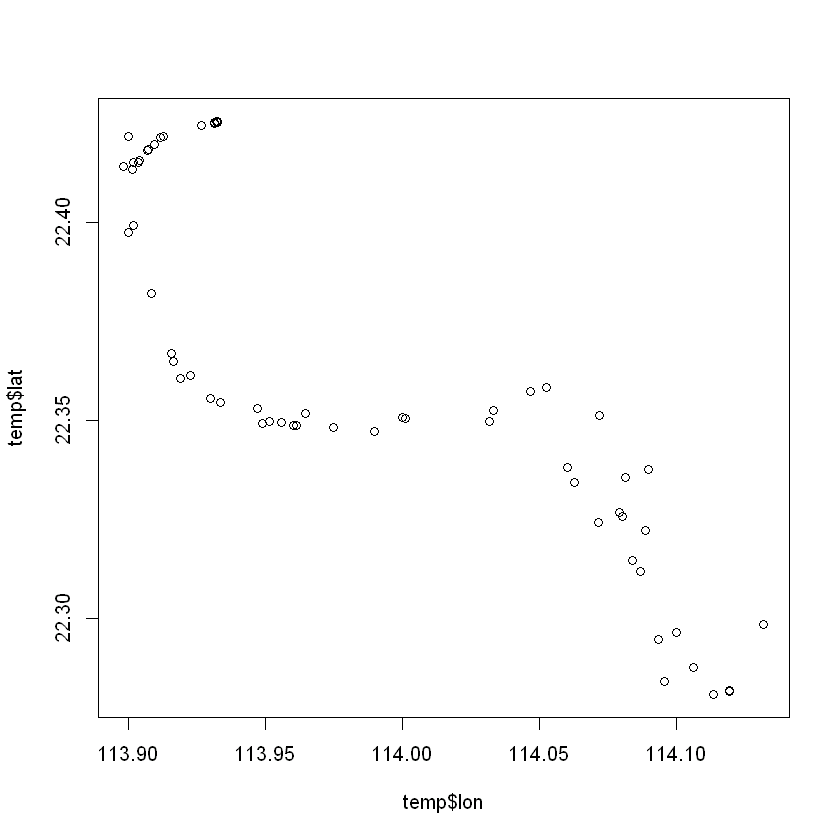

In [472]:
s=dt[mmsi==mmsis[2]]
temp=sample_frac(s,0.001)
nrow(temp)

plot(temp$lon,temp$lat)

In [498]:
#get all stay points and their clusters
staypoints1=res[,list(.N,lon=mean(.SD$lon),lat=mean(.SD$lat)),list(mmsi,stayid)];dim(staypoints1)
staypoints2=res[,list(.N,lon=mean(.SD$lon),lat=mean(.SD$lat)),list(mmsi,sid)];dim(staypoints2)

[1] 190968      5

[1] 39843     5

In [500]:
dim(staypoints2[sid>0])

[1] 36399     5

In [517]:
mdt=as.matrix(staypoints2[sid>0,list(lon,lat)])
cl=dbscan(mdt,0.01,3)
ts=data.table(staypoints2,tid=cl$cluster)[tid>0]
ts=ts[,list(.N,lon=mean(.SD$lon),lat=mean(.SD$lat)),tid]
dim(ts)

Warning message in data.table(staypoints2, tid = cl$cluster):
"Item 2 is of size 36399 but maximum size is 39843 (recycled leaving remainder of 3444 items)"

[1] 777   4

In [518]:
write.csv(staypoints2[sid>0],'../data/individual_ship_based/candidates_berth.csv');
write.csv(ts,'../data/individual_ship_based/candidates_terminals.csv');


In [ ]:
data2shp(staypoints2[sid>0],'../data/individual_ship_based/candidates_berth.shp');
data2shp(ts,'../data/individual_ship_based/candidates_terminals.shp');

In [ ]:
#only to detect the stay points
options(warn=1)
n=length(mmsis);n
#n=5 #for test purpose
r0=data.table(mmsi=0,stayid=0,startpid=0,endpid=0,duration=0,lon=0,lat=0)[mmsi<0]
system.time(
for (i in seq(1,1)){
    print(i)
    s=dt[mmsi==mmsis[i]]
    temp=s[sog==0&status==5];
    sp=getStayPoint(temp,eps=3600*2,minp=5);sp=sp[stayid>0]
    if(nrow(sp)>0){
       r0=rbind(r0,sp) 
    }
}
)
head(r0)


[1] 3602